<a href="https://colab.research.google.com/github/nathsmo/Elements-of-ML/blob/master/Laboratorio_4_EoML_Nathalia_Morales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorio 4

##Nathalia Morales

En este laboratorio usaremos cuatro tipo de clasificadores sobre datos de bolsa de valores para predecir si el mercado está de subida o de bajada para cierta fecha. Los datos están en https://github.com/JWarmenhoven/ISLR-python/blob/master/Notebooks/Data/Smarket.csv.

In [0]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns

import statsmodels
import statsmodels.formula.api as smf

print("Todos los paquetes han sido importados:")
print("Numpy version: {}".format(np.__version__))
print("Pandas version: {}".format(pd.__version__))
print("Matplotlib version: {}".format(matplotlib.__version__))
print("Seaborn version: {}".format(sns.__version__))
print("Statsmodels-learn version: {}".format(statsmodels.__version__))

Todos los paquetes han sido importados:
Numpy version: 1.14.6
Pandas version: 0.22.0
Matplotlib version: 3.0.2
Seaborn version: 0.7.1
Statsmodels-learn version: 0.8.0


## Explorando los datos

Las variables en smarket son


*   Año
*   Lag1 a Lag5: porcentaje de retornos de los cinco días previos
*   Volume: el número de intercambios el día previo en billones
*   Today: porcentaje de retorno en ese día
*   Direction: si el mercado está de subida o bajada ese día

In [0]:
url = 'https://raw.githubusercontent.com/JWarmenhoven/ISLR-python/master/Notebooks/Data/Smarket.csv'
smarket = pd.read_csv(url)
smarket = smarket.drop('Unnamed: 0', axis=1)

smarket.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.1913,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.2965,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.4112,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.2760,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.2057,0.213,Up


In [0]:
smarket.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1250.000000,1250.000000,1250.000000,1250.000000,1250.000000,1250.00000,1250.000000,1250.000000
mean,2003.016000,0.003834,0.003919,0.001716,0.001636,0.00561,1.478305,0.003138
std,1.409018,1.136299,1.136280,1.138703,1.138774,1.14755,0.360357,1.136334
min,2001.000000,-4.922000,-4.922000,-4.922000,-4.922000,-4.92200,0.356070,-4.922000
25%,2002.000000,-0.639500,-0.639500,-0.640000,-0.640000,-0.64000,1.257400,-0.639500
50%,2003.000000,0.039000,0.039000,0.038500,0.038500,0.03850,1.422950,0.038500
75%,2004.000000,0.596750,0.596750,0.596750,0.596750,0.59700,1.641675,0.596750
max,2005.000000,5.733000,5.733000,5.733000,5.733000,5.73300,3.152470,5.733000


Predeciremos direction, que esperamos que sea binario. Verifiquemos que lo es

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


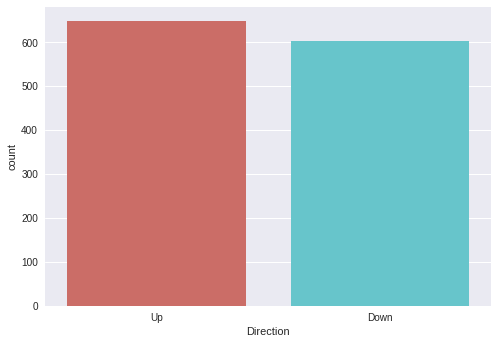

In [0]:
sns.countplot(x='Direction',data=smarket, palette='hls')

Generamos una matriz de correlaciones entre variables para visualizar 

['Year', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume', 'Today', 'Direction']


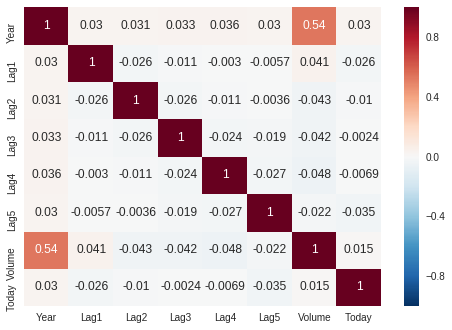

In [0]:
#smarket.corr()

cols = list(smarket)
print(cols)

coefs = np.corrcoef(smarket[cols[0:8]].values.T)
heatMap = sns.heatmap(coefs, annot = True, yticklabels=cols[0:8], xticklabels=cols)

Noten que excluí la columna de Direction porque no es numérica. La única correlación que sobresale es entre volumen y años con 0.539006, las demás son menores a 0.05. Esto último era de esperarse: no parece haber correlacción entre los retornos de hoy y los de días anteriores. Generemos una función de gráfica de dispersión para visualizar la relación entre volumen y año.

In [0]:
def make_scatter_plot(dataframe, input_feature, target,
                      slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with the models.
  
  Args:
    dataframe: the dataframe to visualize
    input_feature: the input feature to be used for the x-axis
    target: the target to be used for the y-axis
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the Scatter plot
  x = dataframe[input_feature]
  y = dataframe[target]
  plt.ylabel(target)
  plt.xlabel(input_feature)
  plt.scatter(x, y, color='black', label="")
  plt.show()

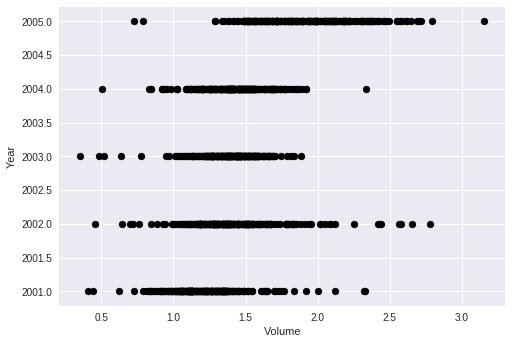

In [0]:
make_scatter_plot(smarket, "Volume", "Year", slopes=[], biases=[], model_names=[])

### Ejercicio

En el laboratorio utilizarás los métodos de clasificación: regresión logística, análisis de discriminante lineal, análisis de discriminante cuadrático y vecinos k-cercanos. Para smarket, cuál crees que será el mejor predictor o el más apropiado para la variable Direction? Los aspectos que debes tomar en cuenta son: número de observaciones, normalidad de la distribución de los datos, no linealidad entre la relación entre los predictores y el target. Responde en la celda de abajo

Yo creo que la mejor forma va a ser la regresion logistica, por la  naturaleza de la data que queremos predecir, dado que los valores de Direction son esencialmente binomiales al ser convertidos de su naturaleza descriptiva sera mas adecuado ese modelo. Depues de todo Logistic Regression sirve para explicar la relación entre una variable binaria dependiente y una o más variables independientes. Se usa para predecir las probabilidades de ser un caso (1 o 0 en este caso) en función de los valores de las variables independientes ( o predictores).


## Análisis (Tarea)

Para cada uno de los cuatro métodos de clasificación, escoge observaciones de entrenamiento y otras de prueba

1.   Genera un modelo de predicción para la variable Direction usando observaciones de entrenamiento
2.   Realiza cuadros de confusión para cada uno



In [0]:
Direction = smarket["Direction"]

for i in range(0,len(Direction)):
  if Direction[i] == "Up":
    Direction[i] = 1
  elif Direction[i] == "Down":
    Direction[i] = 0

In [0]:
X = smarket.loc[:, smarket.columns != 'Direction']
y = Direction

y = y[:1250]
y =y.astype(int)
#y.shape

In [0]:
#X.shape

### Regresión logística

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 1.00


In [0]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[132,   0],
       [  0, 118]])

### Análisis de discriminante lineal

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
LDA = LinearDiscriminantAnalysis()
LDA.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
              solver='svd', store_covariance=False, tol=0.0001)

In [0]:
y_pred = LDA.fit(X_train, y_train).predict(X_test)
print('Accuracy of LDA on test set: {:.2f}'.format(LDA.score(X_test, y_test)))

Accuracy of LDA on test set: 0.97


In [0]:
#print(y_pred.shape)
#print(y_test.shape)

In [0]:
confusion_matrix(y_test, y_pred)

array([[124,   8],
       [  0, 118]])

### Análisis de discriminante cuadrático

In [0]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
y_pred = qda.fit(X_train, y_train).predict(X_test)
print('Accuracy of Quadratic Discriminant Analysis on test set: {:.2f}'.format(qda.score(X_test, y_test)))


Accuracy of Quadratic Discriminant Analysis on test set: 0.94


In [0]:
confusion_matrix(y_test, y_pred)


array([[120,  12],
       [  3, 115]])

### Vecinos k-cercanos

In [0]:
from sklearn.neighbors import KNeighborsClassifier  
classifier = KNeighborsClassifier(n_neighbors=5)  
classifier.fit(X_train, y_train)  
y_pred = classifier.predict(X_test)  
print('Accuracy of K Neighbors Classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))


Accuracy of K Neighbors Classifier on test set: 0.86


In [0]:
confusion_matrix(y_test, y_pred)

array([[112,  20],
       [ 14, 104]])